In [1]:
import json
import time
import h5py

from sklearn.datasets import load_files    
from keras.utils import np_utils
import numpy as np
from glob import glob
from PIL import Image
import os
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Function to load train and test datasets
def load_dataset(path):
    data = load_files(path)
    char_files = np.array([np.array(Image.open(img).convert('L'), 'f') for img in data['filenames']])
    char_labels = np_utils.to_categorical(np.array(data['target']), 138)
    return char_files, char_labels

np.random.seed(1337)

train_images, train_labels = load_dataset('dataset/train')
valid_images, valid_labels = load_dataset('dataset/valid')
test_images, test_labels = load_dataset('dataset/test')
#(train_images, test_images, train_labels, test_labels) = train_test_split(images, labels, test_size=0.3, random_state=seed)
num_classes = train_labels.shape[1]

print('There are %d telugu characters.' % num_classes)
print('There are %d training character images.' % len(train_images))
print('There are %d valid character images.'% len(valid_images))
print('There are %d test character images.'% len(test_images))

print('Training set', train_images.shape, train_labels.shape)
print('Valid set', valid_images.shape, valid_labels.shape)
print('Test set', test_images.shape, test_labels.shape)

Using TensorFlow backend.


Thers are 138 telugu characters.
There are 28586 training character images.
There are 4654 valid character images.
There are 4371 test character images.
Training set (28586, 80, 80) (28586, 138)
Valid set (4654, 80, 80) (4654, 138)
Test set (4371, 80, 80) (4371, 138)


In [2]:
image_size = 80
num_channels = 1 # grayscale

def reformat(images):
    images = images.reshape((-1, image_size, image_size, num_channels))
    return images

train_tensors = reformat(train_images).astype('float32')/255
valid_tensors = reformat(valid_images).astype('float32')/255
test_tensors = reformat(test_images).astype('float32')/255
print('Training Tensor', train_tensors.shape)
print('Valid set', valid_tensors.shape)
print('Test set', test_tensors.shape)

Training Tensor (28586, 80, 80, 1)
Valid set (4654, 80, 80, 1)
Test set (4371, 80, 80, 1)


In [5]:
import os
from keras.preprocessing.image import ImageDataGenerator 

data_augmentation = False
batch_size = 128
n_epochs = 20

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cnn_telugu_character_trained_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)



In [6]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint 

def conv_net_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(image_size, image_size, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))   
              
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
              
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))              
    model.add(Dropout(0.5))
    
    model.add(Dense(138, activation='softmax'))
    
    model.summary()
    
    return model

In [7]:
model = conv_net_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       73856     
__________

In [8]:
learning_rate = 0.1
decay_rate = learning_rate / n_epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

checkpointer = ModelCheckpoint(filepath='saved_models/keras_cnn_telugu_char_trained_model.h5', monitor = 'val_loss',  
                               verbose=0, save_best_only=True, mode = 'auto')

model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

timestamp = int(time.time())
with open('%d-model.json' %timestamp, 'w') as f:
    d = json.loads(model.to_json())
    json.dump(d, f, indent = 4)

        
if data_augmentation:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_tensors)

    # Fit the model on the batches generated by datagen.flow().
    with h5py.File(model_path, 'r') as f:
        history = model.fit_generator(datagen.flow(train_tensors, train_labels,
                                     batch_size=32),
                        steps_per_epoch=int(np.ceil(train_tensors.shape[0] / float(batch_size))),
                        epochs=n_epochs,
                        validation_data = (valid_tensors, valid_labels), 
                        callbacks = [checkpointer], 
                        verbose = 1)
    
else:
    print('Not using data augmentation.')
    
    with h5py.File(model_path, 'r') as f:
        history = model.fit(train_tensors, train_labels, epochs = n_epochs, validation_data = (valid_tensors, valid_labels), batch_size = 128, shuffle = 'batch', verbose=1)
        
model.save(model_path)
# Final evaluation of the model
scores = model.evaluate(test_tensors, test_labels, verbose=0)

print('Large CNN Error: %.2f%%' % (100-scores[1]*100))
print('Test loss:', scores[0])
print('Test Accuracy : %.2f%%' % scores[1])

model.save_weights('%d-weights-%f.hdf5' %(timestamp, scores[1]))

Not using data augmentation.
Train on 28586 samples, validate on 4654 samples
Epoch 1/20
28586/28586 [==============================] - 440s 15ms/step - loss: 4.4217 - acc: 0.0747 - val_loss: 2.3859 - val_acc: 0.3954
Epoch 2/20
28586/28586 [==============================] - 444s 16ms/step - loss: 1.8240 - acc: 0.4985 - val_loss: 0.9702 - val_acc: 0.7209
Epoch 3/20
28586/28586 [==============================] - 444s 16ms/step - loss: 1.0357 - acc: 0.6932 - val_loss: 0.6335 - val_acc: 0.8135
Epoch 4/20
28586/28586 [==============================] - 438s 15ms/step - loss: 0.7600 - acc: 0.7661 - val_loss: 0.5370 - val_acc: 0.8429
Epoch 5/20
28586/28586 [==============================] - 435s 15ms/step - loss: 0.6049 - acc: 0.8100 - val_loss: 0.4944 - val_acc: 0.8550
Epoch 6/20
28586/28586 [==============================] - 499s 17ms/step - loss: 0.5165 - acc: 0.8364 - val_loss: 0.4505 - val_acc: 0.8717
Epoch 7/20
28586/28586 [==============================] - 642s 22ms/step - loss: 0.4386 

dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])


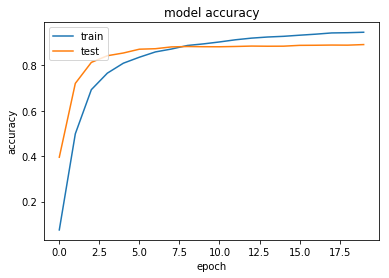

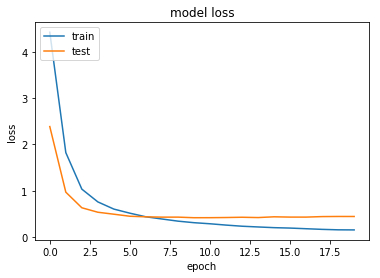

In [9]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
preds = model.predict(test_tensors)
predicts = np.argmax(preds, axis = 1)
Y_test = np.argmax(test_labels, axis =1)

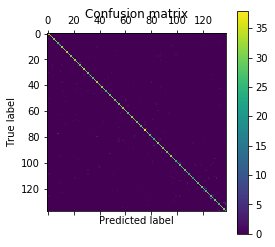

In [51]:
cm = confusion_matrix(Y_test, predicts)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [97]:
print('Actual_labels  |  Predicted_labels')
for i in range(50):
    print('      %3d      |     %3d' %(Y_test[i], predicts[i]))

Actual_labels  |  Predicted_labels
       47      |      47
      110      |     110
       46      |      41
      134      |     134
       60      |      60
       67      |      67
       68      |      68
       59      |      59
      121      |     121
       65      |      65
       15      |      15
      119      |     119
      119      |     119
       72      |      72
       44      |      44
       45      |      45
       34      |      34
      126      |     128
       55      |      55
      124      |     124
       21      |      21
      128      |     128
        6      |       6
      121      |     121
       42      |      42
       24      |      24
      107      |     107
      135      |     135
       26      |      26
       28      |      28
       34      |      34
       18      |      18
       44      |      44
       83      |      58
       37      |      37
       44      |      44
       86      |      86
       67      |      67
       85      